<a href="https://colab.research.google.com/github/QcoJuanDavidMarin/repo_Diplomado_I_A/blob/main/ProyectofinalDiplomadoJDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="color:green"><center>**Diplomado en Inteligencia Artificial y Aprendizaje Profundo**</center></span>


## <span style="color:red"><center>Proyecto final del diplomado, </center></span>

## <span style="color:red"><center>DETECCIÓN Y LOCALIZACIÓN DE TUMORES CEREBRALES MEDIANTE RECONOCIMIENTO DE IMAGENES DE RESONANCIA MAGNETICA</center></span>

* <span style="color:red"><center>Por Juan David Marín</center></span>

Este es un proyecto enfocado específicamente al sector de la salud, al sector de la sanidad y de la medicina. Especificamente se trata de analizar todas las imágenes de una de una una resonancia magnética del cerebro.


[fuente de los datos](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)

## Importar librerias 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import zipfile
import cv2
from skimage import io  # procesamiento de imágenes 
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121 ## Densenet121
from tensorflow.keras.applications.resnet50 import ResNet50 ## ResNet50, red neuronal residual
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform #Extraer muestras de una distribución uniforme
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from IPython.display import display
from tensorflow.keras import backend as K  
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob # buscador todos los nombres de ruta que coinciden con un patrón especificado
import random
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline



In [3]:
# montar disco usando los siguientes comandos:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Navegar hasta el directorio My Drive para cambiar el directorio de trabajo
%cd /content/drive/MyDrive/Proyecto final Diplomado IAAP /Healthcare AI Datasets/Brain_MRI

/content/drive/.shortcut-targets-by-id/1OShySL557_0nwSYbP9jwv6JrtkAUC4nM/Proyecto final Diplomado IAAP /Healthcare AI Datasets/Brain_MRI


In [5]:
# Datos que contienen la ruta a Brain MRI y su máscara correspondient donde uno indica si tiene cancer y cero que no
brain_df = pd.read_csv('data_mask.csv')
brain_df.head()


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [6]:
# Ruta a la imagen de la resonancia magnetica para el primer paciente
brain_df.mask_path[0] 

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

In [7]:
# Ruta máscara de segmentación para el primer paciente
brain_df.image_path[0] 

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

In [9]:
# Contar cuantos casos son 1 y cuantos son 0
x1 = brain_df['mask'].value_counts()[0]
x2 = brain_df['mask'].value_counts()[1]
print(x1)
print(x2)

2556
1373


In [10]:
y1 = brain_df['mask'].value_counts().index[0]
y2 = brain_df['mask'].value_counts().index[1]
print(y1)
print(y2)

0
1


In [11]:
# diagrama de barras de las categorias
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts(), name='MASK')])
fig.update_traces(marker_color = 'rgb(250,0,0)', marker_line_color = 'rgb(150,0,0)',marker_line_width = 8, opacity = 0.5)
fig.update_layout(barmode='group')
fig.update_yaxes(title_text="mask")
fig.show()


In [ ]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

## Mostrar una imagen de una mascara

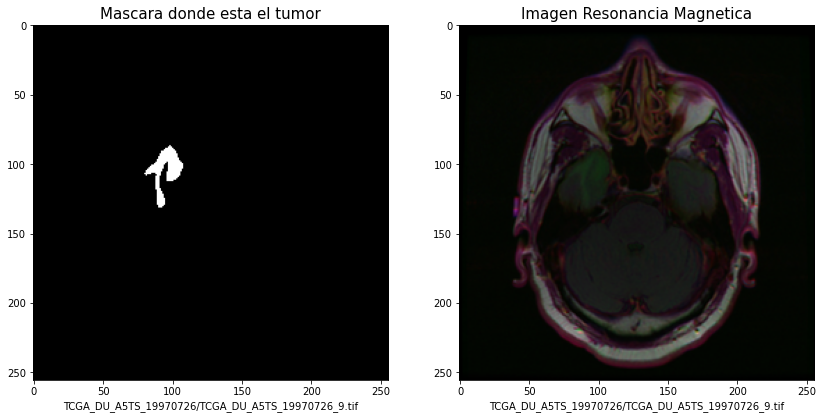

In [12]:
plt.figure(figsize = (14,7))
plt.subplot(121)
plt.imshow(cv2.imread(brain_df.mask_path[923]))
plt.title('Mascara donde esta el tumor', fontsize = 15)
plt.xlabel(brain_df.image_path[923])

plt.subplot(122)
plt.imshow(cv2.imread(brain_df.image_path[923]))
plt.title('Imagen Resonancia Magnetica', fontsize = 15)
plt.xlabel(brain_df.image_path[923])
plt.show()

In [ ]:
print('La dimención maxima de la imagen de la mascara es', cv2.imread(brain_df.mask_path[923]).max())
print('La dimención minima de la imagen de la mascara es', cv2.imread(brain_df.mask_path[923]).min())
print('\n')
print('La dimención maxima de la imagen de resonancia magnetica es', cv2.imread(brain_df.image_path[923]).max())
print('La dimención minima de la imagen de resonancia magnetica es', cv2.imread(brain_df.image_path[923]).min())

La dimención maxima de la imagen de la mascara es 255
La dimención minima de la imagen de la mascara es 0


La dimención maxima de la imagen de resonancia magnetica es 210
La dimención minima de la imagen de resonancia magnetica es 0


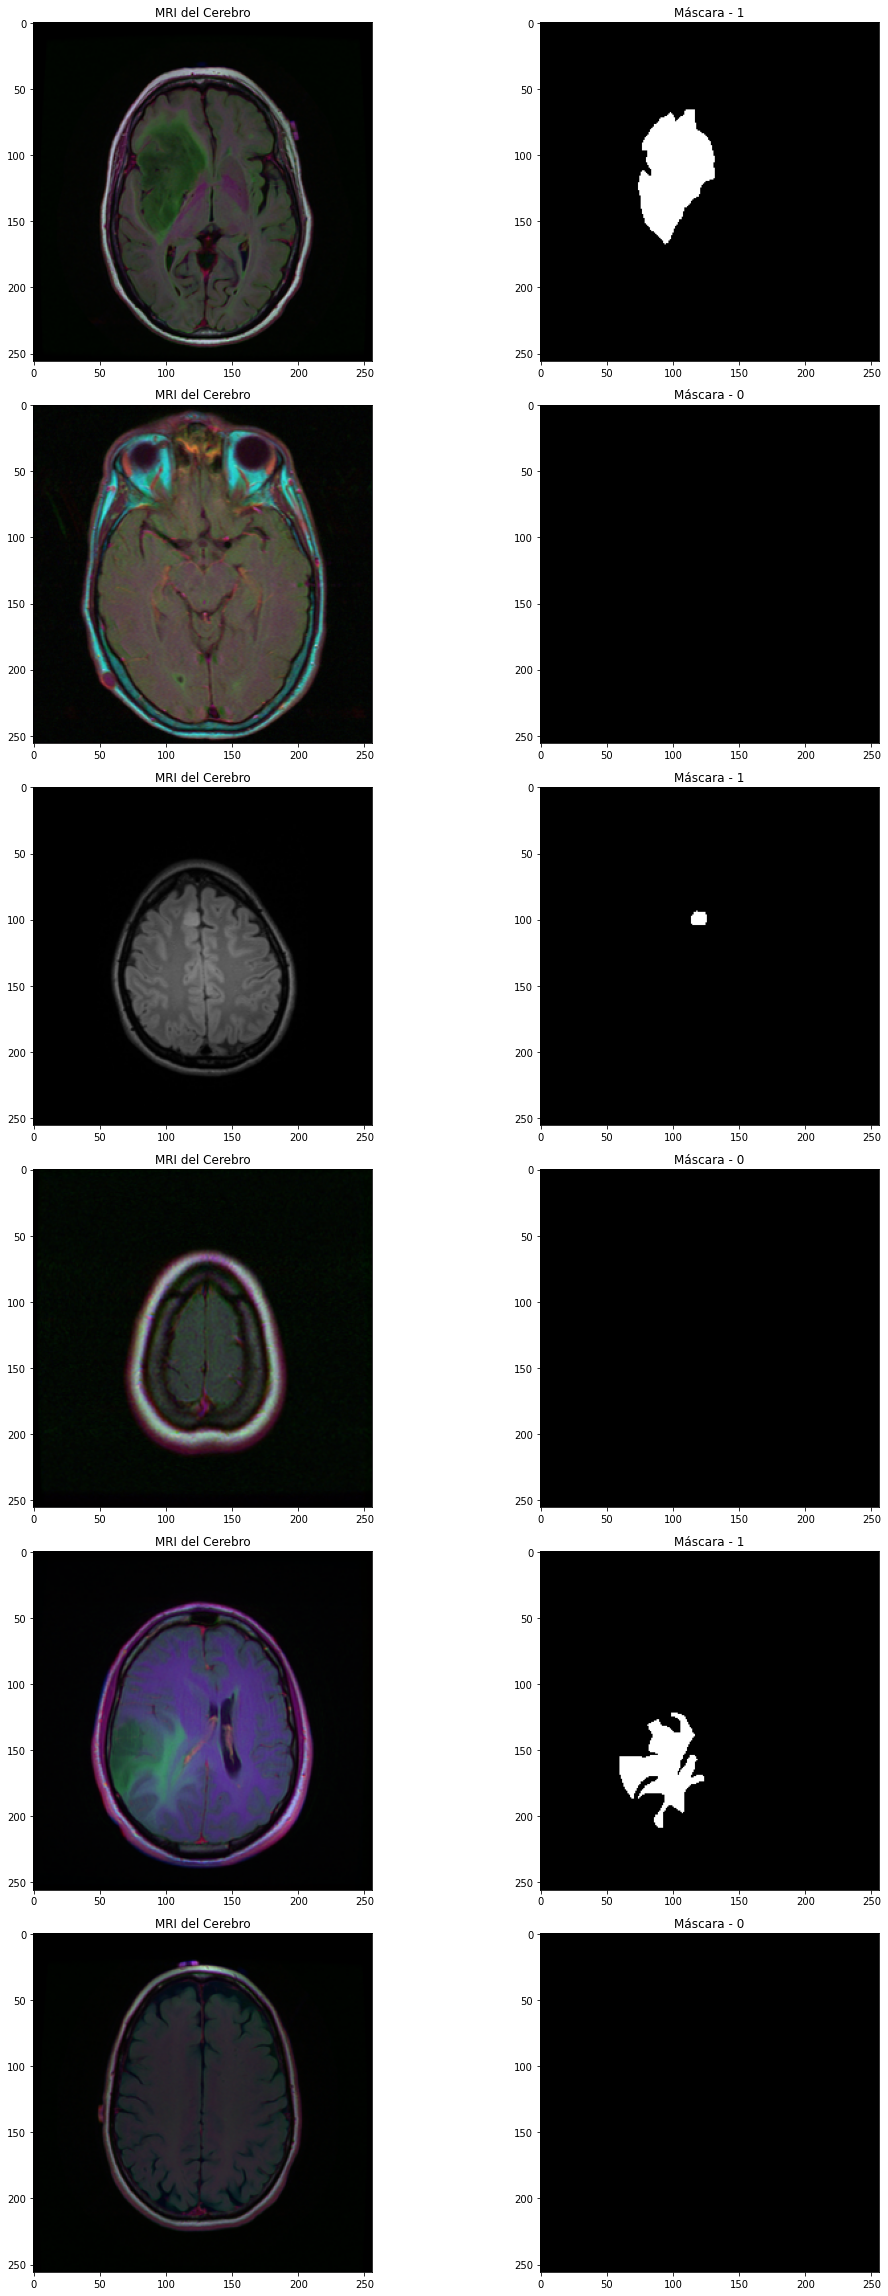

In [13]:
# Visualizar imágenes (MRI y Máscaras) en el dataset de forma separada
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostramos la MRI 
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostramos la máscara correspondiente 
  count += 1

fig.tight_layout()

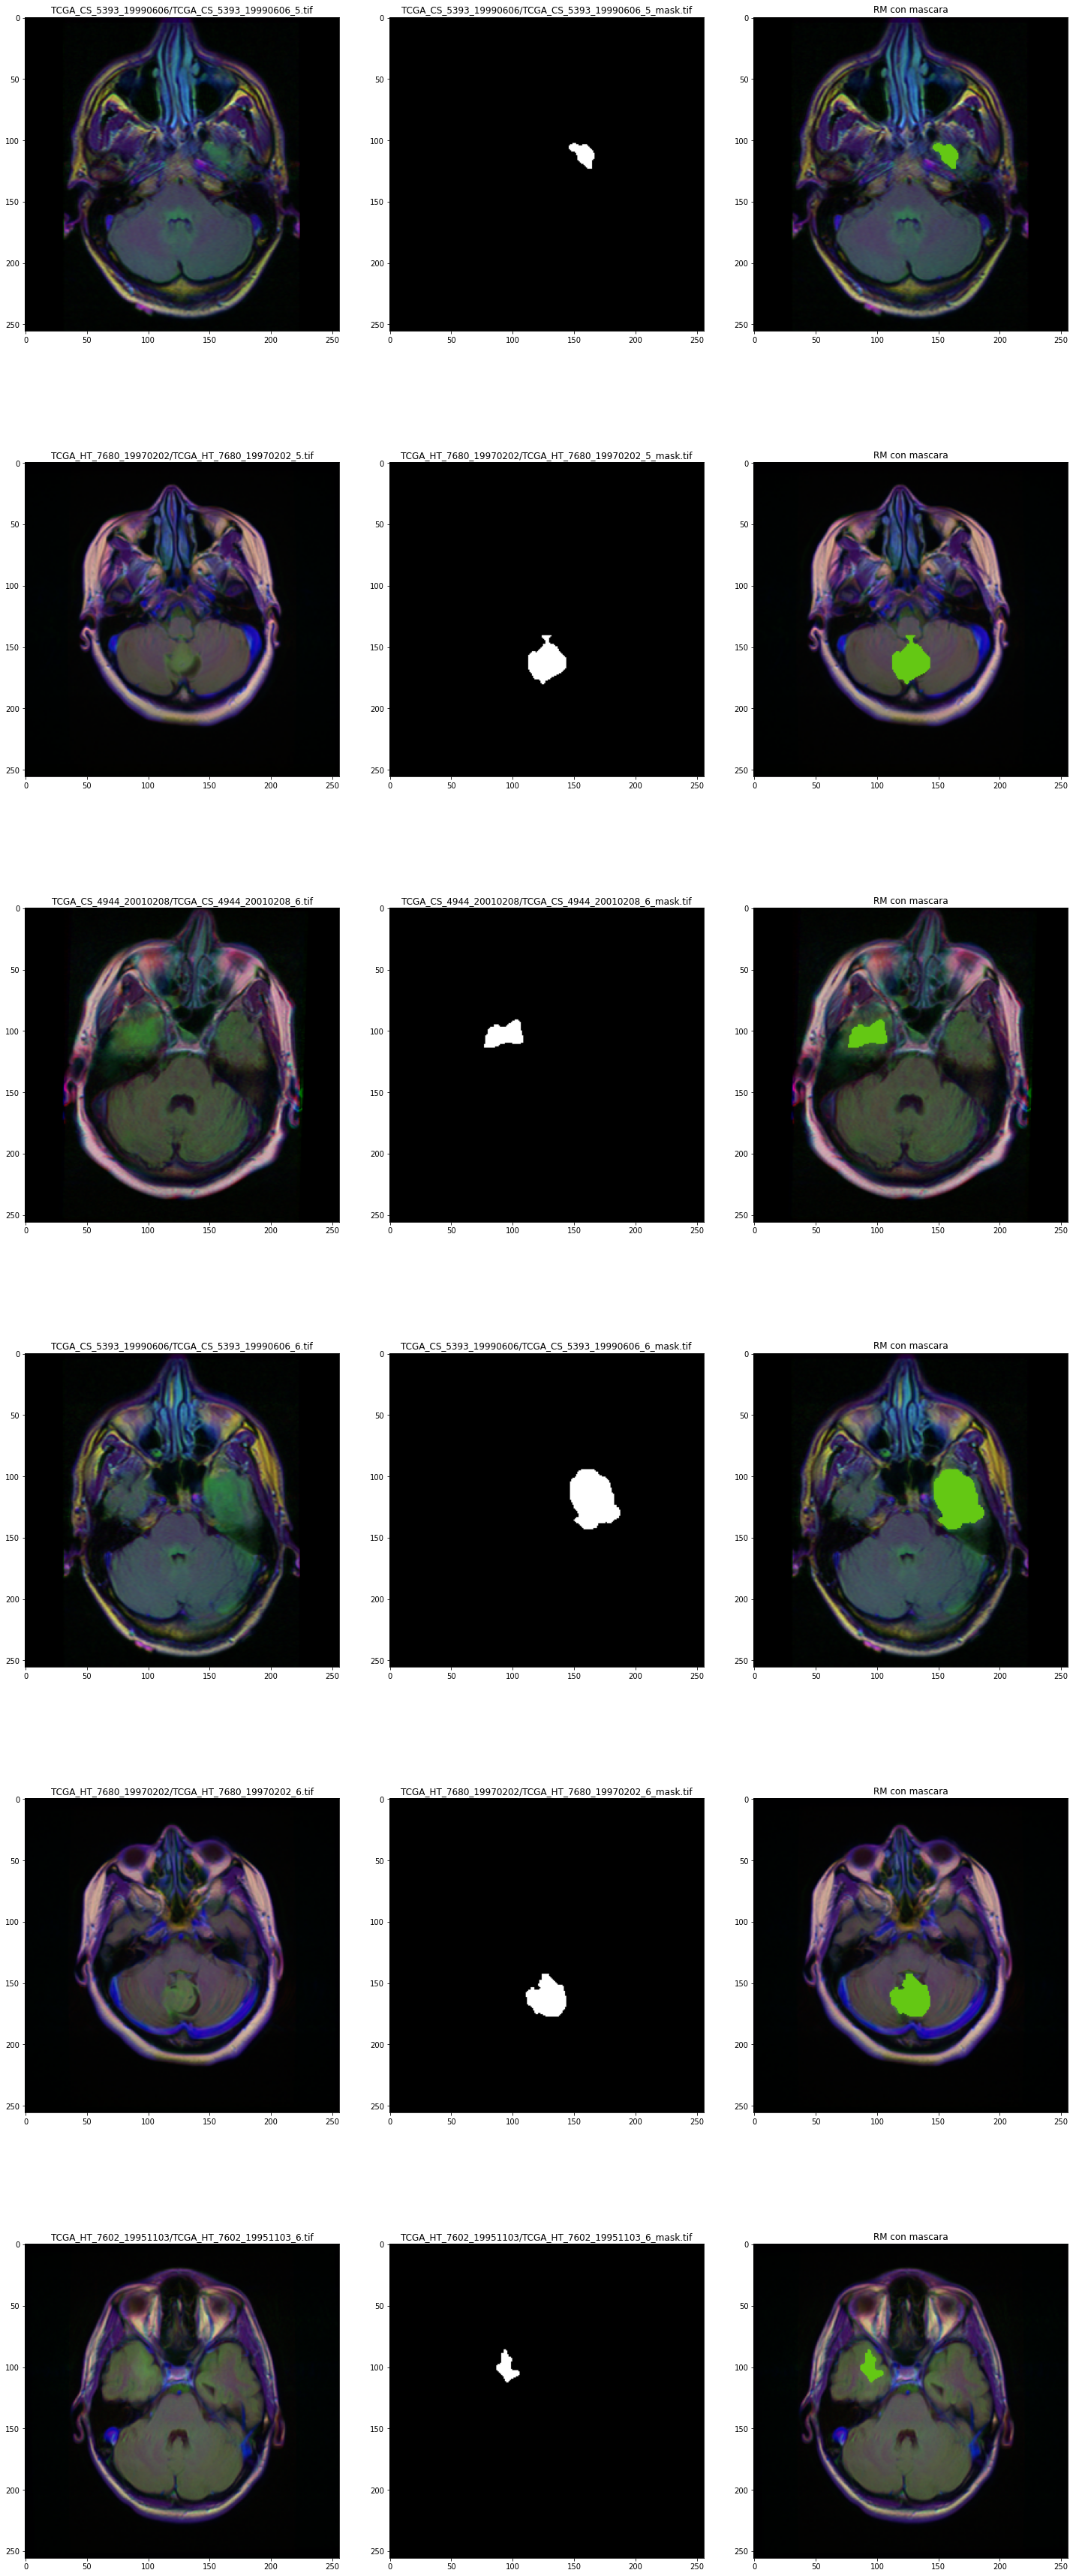

In [ ]:
fig, ax = plt.subplots(6, 3, figsize = (20, 50))
count = 0
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count <6:

    img = io.imread(brain_df.image_path[i])
    ax[count][0].title.set_text(brain_df.image_path[i])
    ax[count][0].imshow(img)
    mascara = io.imread(brain_df.mask_path[i])
    ax[count][1].title.set_text(brain_df.mask_path[i])
    ax[count][1].imshow(mascara,cmap  = 'gray')
  
    img[mascara == 255] = (100, 200, 20)
    ax[count][2].title.set_text('RM con mascara')
    ax[count][2].imshow(img)
    count += 1

fig.tight_layout() # Ajustar en ancho y alto de la zona de dibujo

# MODELO CLASIFICADOR PARA DETECTAR SI EXISTE TUMOR O NO

In [14]:
# Eliminamos la columna de identificador del paciente porque no aporta a la construcción del modelo

brain_df_train = brain_df.drop(columns = ['patient_id'])

print('Tamaño datos originales', brain_df.shape)
print('Tamaño del nuevo conjunto de datos',brain_df_train.shape)

Tamaño datos originales (3929, 4)
Tamaño del nuevo conjunto de datos (3929, 3)


In [15]:
# Convertir los datos en la columna de máscara a formato de string, porque para ingresar tensorflow en flow_from_dataframe los datos deben ser en strings 

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
#brain_df_train['mask'] = str(brain_df_train['mask'])
print(brain_df.info(), '\n')
print(brain_df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB
None


# Entubamiento de datos

# Dividir los datos en entrenamiento y testing

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [17]:
brain_df_train['mask'].value_counts().index


Index(['0', '1'], dtype='object')

In [18]:
# Cargar LIBRERIA PARA ingresar imagenes por batches

from tensorflow.keras.preprocessing.image import ImageDataGenerator # Preprocesar las imagenes que van a estrar al algoritmo 

In [19]:
# Generador de datos para entubamiento
datagen = ImageDataGenerator(rescale=1/255.,validation_split = 0.15) # Validation_split para que la Red no memorize 


In [20]:
# Dimension de las imagenes para saber como deben entrar 
cv2.imread(brain_df.mask_path[923]).shape

(256, 256, 3)

# Generando data de entrenamiento 

In [21]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory  = './', # Directorio donde nos encontramos 
    x_col = 'image_path', # Posición de las imagenes RM
    y_col = 'mask', # Lo que se quiere predecir 
    subset= 'training',
    batch_size = 16,
    shuffe = True,
    class_mode = 'categorical',
    target_size = (256,256))

Found 2839 validated image filenames belonging to 2 classes.


# Generando data de validación 

In [22]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation', # correspondiente al 15% (validation split)
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256,256))

Found 500 validated image filenames belonging to 2 classes.


# Imagenes de prueba 

In [23]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256,256))

Found 590 validated image filenames belonging to 2 classes.


# Modelo simple (Modelo prueba 1)

# Modelo creado con la API funcional 

In [41]:
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv1 = Conv2D(32, 3, strides=2, padding="same")
        self.nomalization1 = BatchNormalization()
        self.activation1 = Activation("relu")
        self.maxpooling1 = MaxPooling2D(3, strides=2, padding="same")
        self.dropout1 = Dropout(0.4)
        self.conv2 = Conv2D(64, 3, strides=2, padding="same")
        self.nomalization2 = BatchNormalization()
        self.activation2 = Activation("relu")
        self.global_average = GlobalAveragePooling2D()
        self.flatten= Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(2, activation='softmax')

    def call(self,x):
        x = self.conv1(x)
        x = self.nomalization1(x)
        x = self.activation1(x)
        x = self.maxpooling1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.nomalization2(x)
        x = self.activation2(x)
        x = self.global_average(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# crea una instancia del modelo
model = MyModel()

# Compilar el modelo 1

In [42]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [43]:
class MNIST_Callback(tf.keras.callbacks.Callback):
    
    # método dentro de la clase myCallback, heredada de la clase Callback de keras
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.985):
            print("\nSe alcanzó un 98.5% de precisión en la validación! Cancelando Entrenamiento...")
            self.model.stop_training = True

# crea una instancia de clase
accu_callback = MNIST_Callback()

# Entrenar el modelo 1

In [44]:
history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=valid_generator,
                              shuffle=True,
                              callbacks = [accu_callback])

Epoch 1/15
178/178 [==============================] - 12s 62ms/step - loss: 0.5823 - accuracy: 0.6729 - val_loss: 1.6338 - val_accuracy: 0.3460
Epoch 2/15
178/178 [==============================] - 11s 61ms/step - loss: 0.4948 - accuracy: 0.7457 - val_loss: 1.4743 - val_accuracy: 0.3460
Epoch 3/15
178/178 [==============================] - 10s 58ms/step - loss: 0.4749 - accuracy: 0.7524 - val_loss: 0.7676 - val_accuracy: 0.5000
Epoch 4/15
178/178 [==============================] - 10s 58ms/step - loss: 0.4653 - accuracy: 0.7653 - val_loss: 0.6880 - val_accuracy: 0.5900
Epoch 5/15
178/178 [==============================] - 10s 58ms/step - loss: 0.4615 - accuracy: 0.7717 - val_loss: 0.5254 - val_accuracy: 0.7020
Epoch 6/15
178/178 [==============================] - 10s 56ms/step - loss: 0.4665 - accuracy: 0.7471 - val_loss: 0.5898 - val_accuracy: 0.7060
Epoch 7/15
178/178 [==============================] - 10s 58ms/step - loss: 0.4526 - accuracy: 0.7493 - val_loss: 0.4882 - val_accuracy:

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256

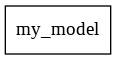

In [32]:
model.summary()
plot_model(model,show_shapes=True)

In [60]:
path = './model1'
if not os.path.exists(path):
    os.mkdir(path)
model.save('./model1/model1.tf')
model.save_weights('./model1/pesos_model1.tf')

INFO:tensorflow:Assets written to: ./model1/model1.tf/assets


# Graficos de perdida y accuracy para el primer modelo

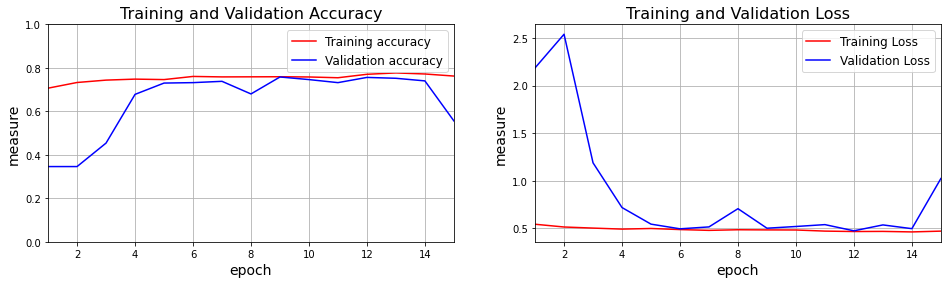

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r-', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b-', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_ylim(0,1)
ax[0].grid()
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b-', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])
ax[1].grid()

plt.show()

# Aumentando capas con modelo secuencial y activación sigmoide

In [52]:

model_sec = tf.keras.models.Sequential([
                                    Conv2D(32, 3,activation='relu',  input_shape= (256, 256, 3)),
                                    BatchNormalization(),
                                    Activation("relu"),
                                    MaxPooling2D(3,strides=2, padding='same'),
                                    Dropout(0.4),
                                    Conv2D(64,3,strides=2,padding='same'),
                                    BatchNormalization(),
                                    Activation('relu'),
                                    Flatten(),
                                    Dense(256, activation='relu'),
                                    Dense(128, activation='relu'),
                                    Dense(2, activation='sigmoid')
                                                         
])

In [53]:
# Compilar 
model_sec.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])


In [57]:

# Callbacks
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath='./model_sec',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]


In [58]:
history = model_sec.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=valid_generator,
                              shuffle=True,
                              callbacks = [callbacks])

Epoch 1/20
178/178 [==============================] - 12s 62ms/step - loss: 8.2114 - accuracy: 0.6557 - val_loss: 0.8001 - val_accuracy: 0.6620

Epoch 00001: val_loss improved from inf to 0.80010, saving model to ./model_sec
INFO:tensorflow:Assets written to: ./model_sec/assets
Epoch 2/20
178/178 [==============================] - 12s 67ms/step - loss: 0.3961 - accuracy: 0.8597 - val_loss: 0.5183 - val_accuracy: 0.7600

Epoch 00002: val_loss improved from 0.80010 to 0.51825, saving model to ./model_sec
INFO:tensorflow:Assets written to: ./model_sec/assets
Epoch 3/20
178/178 [==============================] - 12s 67ms/step - loss: 0.3786 - accuracy: 0.8649 - val_loss: 0.3332 - val_accuracy: 0.8380

Epoch 00003: val_loss improved from 0.51825 to 0.33321, saving model to ./model_sec
INFO:tensorflow:Assets written to: ./model_sec/assets
Epoch 4/20
178/178 [==============================] - 12s 67ms/step - loss: 0.2630 - accuracy: 0.8952 - val_loss: 0.3769 - val_accuracy: 0.8480

Epoch 0000

In [59]:
path = './model_sec'
if not os.path.exists(path):
    os.mkdir(path)
model_sec.save('./model_sec/model_sec.h5')
model_sec.save_weights('./model_sec/pesos_model_sec.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 64)       

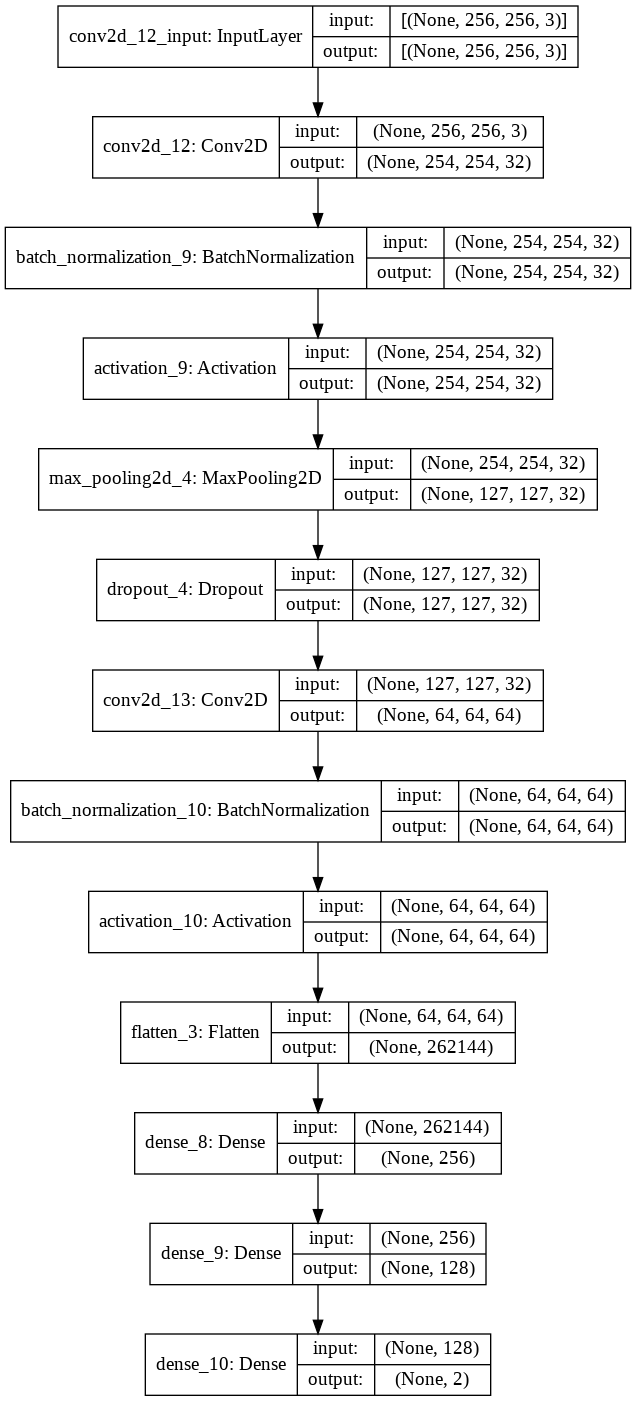

In [61]:
model_sec.summary()
plot_model(model_sec,show_shapes=True)

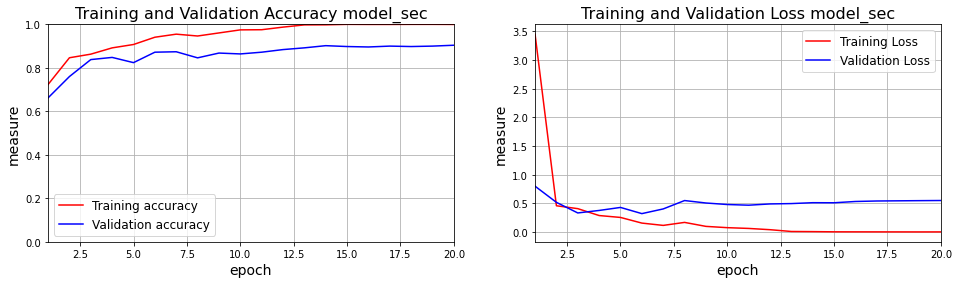

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

n_row = 1
n_col = 2
fig, ax = plt.subplots(n_row, n_col, sharex = False, sharey = False, figsize=(16,4))


ax[0].plot(epochs, acc, 'r-', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b-', label='Validation accuracy')
ax[0].legend(fontsize=12,loc=0)
ax[0].set_title('Training and Validation Accuracy model_sec',fontsize=16)
ax[0].set_ylabel('measure',fontsize=14)
ax[0].set_xlabel('epoch', fontsize = 14)
ax[0].set_ylim(0,1)
ax[0].grid()
ax[0].set_xlim([1, len(acc)])

ax[1].plot(epochs, loss, 'r-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b-', label='Validation Loss')
ax[1].legend(fontsize=12)
ax[1].set_title('Training and Validation Loss model_sec',fontsize=16)
ax[1].set_ylabel('measure',fontsize=14)
ax[1].set_xlabel('epoch', fontsize = 14)
ax[1].set_xlim([1, len(acc)])
ax[1].grid()

plt.show()


#<span style="color:red"><center>**Modelo base ResNet50**</center></span>

In [ ]:

basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
# Se ajusta a falso el parámetro de include_top, ya que no es necesario, más adelante se acoplará la salida de dos categorías que se refieren a detectado o no detectado

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
basemodel.summary()

In [ ]:
# Congelar los pesos del modelo para que no se entrene mas ninguna de las capas
for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Agregar al final la clasificación binaria al modelo base personalizada
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='Flatten')(headmodel)

headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)

headmodel = Dense(2, activation='sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

# Compilar el modelo

In [ ]:
model.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])

# Callbacks

In [ ]:



# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]




# Entrenar el modelo

In [ ]:
train_generator.n//16

177

In [ ]:
steps_per_epoch = train_generator.n // 16 # Dividido en 16 por que son la cantidad de imagenes que se van ingresando
print(test_predict)


NameError: ignored

In [ ]:

history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch= steps_per_epoch, 
                    epochs = 20,
                    validation_steps= steps_per_epoch, 
                    verbose = 1,
                    callbacks= callbacks)


Epoch 1/20
177/177 [==============================] - 91s 477ms/step - loss: 0.0535 - accuracy: 0.9401 - val_loss: 0.1128 - val_accuracy: 0.8700

Epoch 00001: val_loss improved from inf to 0.11278, saving model to /content/drive/My Drive/Proyecto final Diplomado IAAP /Healthcare AI Datasets/Brain_MRI/saved_models/colorized_ae_model.001.h5
Epoch 2/20
177/177 [==============================] - 84s 473ms/step - loss: 0.0459 - accuracy: 0.9454 - val_loss: 0.0703 - val_accuracy: 0.9160

Epoch 00002: val_loss improved from 0.11278 to 0.07032, saving model to /content/drive/My Drive/Proyecto final Diplomado IAAP /Healthcare AI Datasets/Brain_MRI/saved_models/colorized_ae_model.002.h5
Epoch 3/20
177/177 [==============================] - 84s 473ms/step - loss: 0.0460 - accuracy: 0.9398 - val_loss: 0.0726 - val_accuracy: 0.9220

Epoch 00003: val_loss did not improve from 0.07032
Epoch 4/20
177/177 [==============================] - 84s 473ms/step - loss: 0.0389 - accuracy: 0.9516 - val_loss: 0.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,lr,epoch
15,0.054514,0.938363,0.068846,0.924,0.001000,15
16,0.032670,0.962806,0.044505,0.940,0.001000,16
17,0.019253,0.978038,0.037155,0.952,0.000316,17
18,0.015838,0.981934,0.033792,0.958,0.000316,18
19,0.015759,0.981934,0.038264,0.956,0.000316,19


## Perdida 


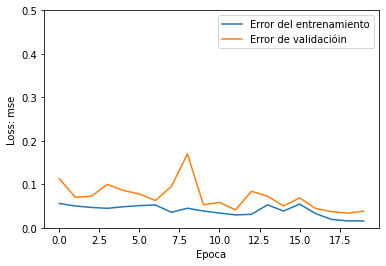

In [ ]:
plt.figure()
plt.xlabel('Epoca')
plt.ylabel('Loss: mse')
plt.plot(hist['epoch'], hist['loss'],
         label = 'Error del entrenamiento')
plt.plot(hist['epoch'], hist['val_loss'],
         label = 'Error de validacióin')
plt.legend()
plt.ylim([0,0.5])
plt.show()

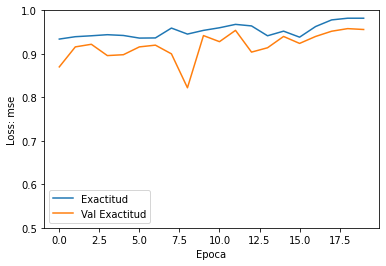

In [ ]:
plt.figure()
plt.xlabel('Epoca')
plt.ylabel('Loss: mse')
plt.plot(hist['epoch'], hist['accuracy'],
         label = 'Exactitud')
plt.plot(hist['epoch'], hist['val_accuracy'],
         label = 'Val Exactitud')
plt.legend()
plt.ylim([0.5,1])
plt.show()

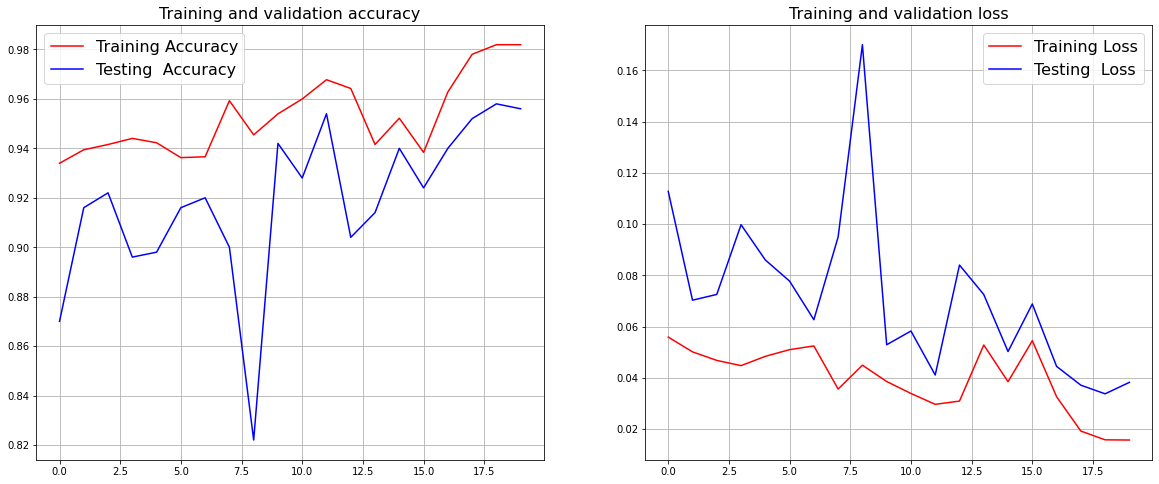

In [ ]:

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history['loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs


plt.figure(figsize=(20,8))
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.subplot(121)
plt.plot  ( epochs,     acc,'r',label='Training Accuracy' )
plt.plot  ( epochs, val_acc,'b',label='Testing  Accuracy' )
plt.title ('Training and validation accuracy',fontsize=16)
plt.grid()
plt.legend(fontsize=16)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.subplot(122)
plt.plot  ( epochs,     loss,'r',label='Training Loss' )
plt.plot  ( epochs, val_loss,'b',label='Testing  Loss' )
plt.title ('Training and validation loss',fontsize=16)
plt.grid()
plt.legend(fontsize=16)
plt.show()

# Guardar el modelo

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
model.save('./modelJDM.h5')


# Predicción 

In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 5s 153ms/step


In [ ]:
print(test_predict.shape)

(576, 2)


In [ ]:
test_predict 

array([[1.0000000e+00, 5.0149836e-08],
       [7.8665704e-01, 2.2284907e-01],
       [9.9927157e-01, 6.5035740e-04],
       ...,
       [9.9999976e-01, 1.5162625e-07],
       [9.9996781e-01, 4.3617834e-05],
       [9.9518448e-01, 4.7294823e-03]], dtype=float32)

# Obtener la clase predicha a partir del modelo


In [ ]:
predict = []
for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '0',
       '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0',
       '1', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0',
       '0', '0', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1',
       '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1',
       '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '1', '0',
       '1', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1', '1', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0

#  Matriz de confusión y classification_report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import pandas as pd

In [ ]:
# Cargamos el modelo preentrenado (en lugar de entrenar el modelo durante más de 1 hora)
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargar el modelo  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])